In [1]:
#import sys
#sys.path.insert(0, '../')
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
from src.data.access import DbAccessLayer, ExternalDataAccessLayer
#from src.data.maintenance import RawData, Database
import warnings
from src.selection.evaluation import create_train_test
from tqdm import tqdm
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
from src.features.generation import add_before_outcomes, add_form, get_bookmaker_pred, get_outcome_counts

In [3]:
db_access = DbAccessLayer()
match_df = db_access.load_table('Match')
odds_df = db_access.load_table('Odds')
match_df = match_df.merge(odds_df.drop(columns=['id']), on='match_id')
match_df = add_before_outcomes(match_df, 15)
match_df = add_form(match_df)
match_df['bookmaker_pred'] = get_bookmaker_pred(match_df)
match_df = pd.concat([match_df, get_outcome_counts(match_df)], axis=1)
match_df

Adding before outcomes: 100%|██████████| 126/126 [00:33<00:00,  3.78it/s]


,match_id,league_id,season,matchday,date,time,home_team_id,away_team_id,table_position_home,table_position_away,...,away_before_15,home_form,away_form,bookmaker_pred,home_wins,home_draws,home_losses,away_wins,away_draws,away_losses
0,2577857,GB1,15/16,1,2015-08-08 00:00:00,3:00 PM,989,405,16,20,...,NaN,0.0,0.0,H,0,0,0,0,0,0
1,2577858,GB1,15/16,1,2015-08-08 00:00:00,5:30 PM,631,2288,10,12,...,NaN,0.0,0.0,H,0,0,0,0,0,0
2,2577860,GB1,15/16,1,2015-08-08 00:00:00,12:45 PM,985,148,5,3,...,NaN,0.0,0.0,H,0,0,0,0,0,0
3,2577861,GB1,15/16,1,2015-08-08 00:00:00,3:00 PM,1003,289,1,17,...,NaN,0.0,0.0,H,0,0,0,0,0,0
4,2577863,GB1,15/16,1,2015-08-08 00:00:00,3:00 PM,1123,873,19,15,...,NaN,0.0,0.0,H,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6027,3615128,IT1,21/22,25,2022-02-14 00:00:00,7:45 PM,3522,430,15,8,...,-1.0,-31.0,-31.0,A,4,2,9,7,2,6
6028,3718405,IT1,21/22,19,2021-12-22 00:00:00,5:30 PM,12,1038,6,15,...,-1.0,5.0,5.0,H,6,6,3,4,1,10
6029,3718646,IT1,21/22,19,2021-12-22 00:00:00,5:30 PM,276,430,13,7,...,1.0,-7.0,-7.0,A,5,6,4,8,2,5
6030,3719028,IT1,21/22,19,2021-12-22 00:00:00,7:45 PM,6195,3522,2,17,...,-1.0,49.0,49.0,H,8,4,3,4,1,10


In [13]:
sites = ['home', 'away']
features = [f'home_before_{i+1}' for i in range(5)] + [f'away_before_{i+1}' for i in range(5)] + ['home_form', 'away_form'] + [f"{s}_losses" for s in sites] + [f"{s}_draws" for s in sites] + [f"{s}_wins" for s in sites] #+ ['table_position_home'] + ['table_position_away']
X_train, X_test, y_train, y_test = create_train_test(df_in=match_df, split_date='2022-07-01', start_date='2010-07-01', features=features, leagues=['L1'])
len(X_train)

1759

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
confusion_matrix(y_test, y_pred)

ValueError: Found array with 0 sample(s) (shape=(0, 18)) while a minimum of 1 is required by GradientBoostingClassifier.

In [16]:
bookmaker_pred = match_df.loc[y_test.index]['BookmakerPred']
print(f"Bookmaker Accuracy: {round(accuracy_score(y_test, bookmaker_pred), 2)}")
confusion_matrix(y_test, bookmaker_pred)

KeyError: 'BookmakerPred'

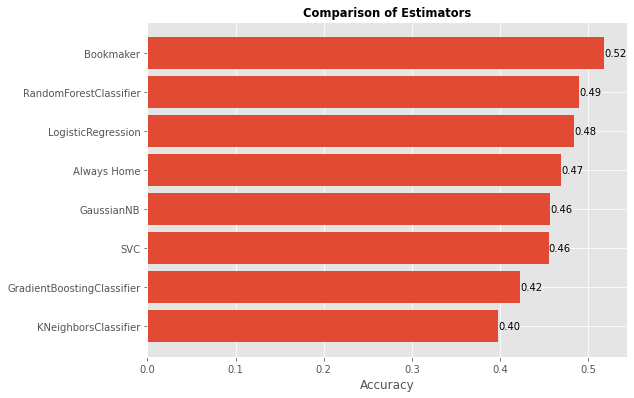

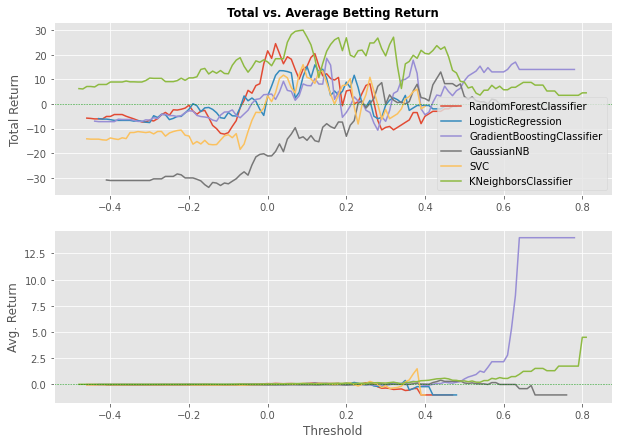

In [17]:
from src.selection.evaluation import compare_estimators
tested_models = [
    RandomForestClassifier(n_estimators=500),
    LogisticRegression(),
    GradientBoostingClassifier(),
    GaussianNB(),
    SVC(probability=True),
    KNeighborsClassifier()
]
bookmaker_pred = get_bookmaker_pred(match_df.loc[X_train.index])
compare_estimators(tested_models, X_train, y_train, match_df, bookmaker_pred)

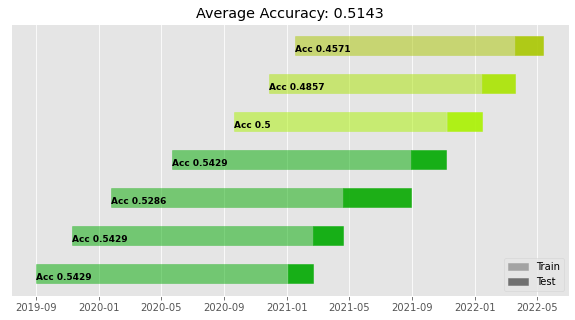

In [269]:
from src.selection.evaluation import temp_cross_validate
train_dates = match_df.loc[X_train.index]['Date']
_ = temp_cross_validate(SVC(), X_train, y_train, visualize=True, dates=train_dates)

In [243]:
1+1

2

In [210]:
import math
from datetime import timedelta
def create_standings_table():
    all_teams = list(set(match_df_n['HomeTeamID'].dropna().tolist() + match_df_n['AwayTeamID'].dropna().tolist()))[:50]
    standings_match_df = match_df_n.copy()
    standings_match_df['Date'] = pd.to_datetime(standings_match_df['Date'])
    standings_df = pd.DataFrame()
    for team_id in tqdm(all_teams):
        team_match_df = standings_match_df[(standings_match_df['HomeTeamID'] == team_id) | (standings_match_df['AwayTeamID'] == team_id)]
        team_seasons = team_match_df['Season'].unique().tolist()
        team_match_df['Role'] = team_match_df['HomeTeamID'].apply(lambda id: 'H' if id == team_id else 'A')
        team_match_df['PointsGained'] = team_match_df.apply(lambda r: 3 if r['FTR'] == r['Role'] else 1 if r['FTR'] == 'D' else 0, axis=1)
        team_standings = pd.DataFrame()
        for season in team_seasons:
            season_df = team_match_df[team_match_df['Season'] == season]

            seasons_split = pd.to_datetime(f"{season[:4]}-07-01")
            # make season start on first tuesday after split (this becomes the regular start of a "game week")
            season_start = seasons_split + timedelta(days=1-seasons_split.weekday())
            season_df['Week'] = season_df['Date'].apply(lambda d: math.floor((d - season_start).days / 7))

            season_standings = season_df.groupby('Week')['PointsGained'].sum().reset_index()
            season_standings['Points'] = season_standings['PointsGained'].cumsum()
            season_standings['Season'] = season
            team_standings = pd.concat([team_standings, season_standings[['Season', 'Week', 'Points']]])
        team_standings['TeamID'] = team_id
        standings_df = pd.concat([standings_df, team_standings])
    return standings_df
standings_df = create_standings_table()

100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


In [211]:
standings_df

,Season,Week,Points,TeamID
0,2000/2001,-20,3,1.0
1,2000/2001,-11,3,1.0
2,2000/2001,-3,3,1.0
3,2000/2001,7,6,1.0
4,2000/2001,10,9,1.0
...,...,...,...,...
24,2020/2021,41,26,50.0
25,2020/2021,42,27,50.0
26,2020/2021,44,30,50.0
27,2020/2021,45,33,50.0


# Scraper

In [2]:
from src.scraper import Scraper
scraper = Scraper()

In [ ]:
#scraper.get_match_data(seasons=[2019], leagues=["ES1"], matchdays=[32, 33, 34, 35, 36, 37, 38])
#scraper.get_match_data(seasons=[2019], leagues=["ES1", "IT1", "FR1"], matchdays=38)

In [5]:
#scraper.fill_missing_team_data()

Getting team data: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


In [3]:
from src.data.access_old import DbAccessLayer as DbAccessLayerOld
teams_df = DbAccessLayer().load_table('Team')
odds_df = DbAccessLayerOld().load_table('Match')
old_teams_df = DbAccessLayerOld().load_table('Team')

In [ ]:
from unidecode import unidecode

db_access = DbAccessLayer()
relations = db_access.load_table("TeamOdds")
unrelated_teams_idx = [i for i, row in teams_df.iterrows() if row['team_id'] not in relations['team_id'].unique()]
unrelated_teams = teams_df.loc[unrelated_teams_idx]

print(f"{len(unrelated_teams_idx)} teams to go")

for i, row in unrelated_teams.iterrows():
    tm_team = row['name']
    team_tokens = tm_team.split(" ")
    matches = []
    for token in team_tokens:
        for j, odds_row in old_teams_df.iterrows():
            odds_team = odds_row['Name']
            odds_team_tokens = [unidecode(e) for e in odds_team.split(" ")]
            if unidecode(token) in odds_team_tokens and token.lower() != "fc":
                matches.append(odds_row)
    if len(matches) > 0:
        matches_df = pd.concat([pd.DataFrame(match).transpose() for match in matches]).drop_duplicates().reset_index()
        print(f"Matches for {tm_team}:")
        for k, match_row in matches_df.iterrows():
            print(f"\t{k+1} - {match_row['Name']}")
        user_in = input("Please insert the numbers you want to establish a connection for, separated by commas. If there is no valid match, insert '-'.")
        if user_in == "-":
            continue
        else:
            idx_to_add = [int(e.strip())-1 for e in user_in.split(",")]
            for idx in idx_to_add:
                odds_team_match = matches_df.loc[idx]
                db_access.save_team_odds_relation(team_id=row['team_id'], odds_team_name=odds_team_match['Name'], odds_team_id=odds_team_match['TeamID'])
        print("\n")

# Odds Creation

In [48]:
db_access = DbAccessLayer()
match_df = db_access.load_table("Match")
odds_relation = db_access.load_table("TeamOdds")

In [61]:
match_df_adj = match_df.copy()
match_df_adj['date'] = pd.to_datetime(match_df_adj['date'])
odds_df['Date'] = pd.to_datetime(odds_df['Date'])
odds_df.dropna(subset=['HomeTeamID', 'AwayTeamID'], inplace=True)
odds_df['HomeTeamID'] = odds_df['HomeTeamID'].astype(int)
odds_df['AwayTeamID'] = odds_df['AwayTeamID'].astype(int)
match_df_adj = match_df_adj.merge(odds_relation[['team_id', 'odds_team_id']], left_on="home_team_id", right_on="team_id").rename(columns={'odds_team_id': 'odds_team_id_home'}).drop(columns=['team_id'])
match_df_adj = match_df_adj.merge(odds_relation[['team_id', 'odds_team_id']], left_on="away_team_id", right_on="team_id").rename(columns={'odds_team_id': 'odds_team_id_away'}).drop(columns=['team_id'])
match_df_adj = match_df_adj.merge(odds_df, left_on=['date', 'odds_team_id_home', 'odds_team_id_away'], right_on=['Date', 'HomeTeamID', 'AwayTeamID'], how='left')
match_df_adj = match_df_adj.sort_values('Date').drop_duplicates(subset=['match_id'])
valid_matches = match_df_adj.dropna(subset=['B365H', 'B365D', 'B365A'])
valid_matches

,match_id,league_id,season,matchday,date,time,home_team_id,away_team_id,table_position_home,table_position_away,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2,HFKC,AFKC
0,2577857,GB1,15/16,1,2015-08-08,3:00 PM,989,405,16,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1523,2577858,GB1,15/16,1,2015-08-08,5:30 PM,631,2288,10,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,2577861,GB1,15/16,1,2015-08-08,3:00 PM,1003,289,1,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,2577865,GB1,15/16,1,2015-08-08,3:00 PM,29,1010,11,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
913,2577863,GB1,15/16,1,2015-08-08,3:00 PM,1123,873,19,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,3592241,GB1,21/22,38,2022-05-22,4:00 PM,31,543,2,8,...,1.83,2.19,1.99,2.07,1.80,NaN,NaN,NaN,NaN,NaN
826,3592214,GB1,21/22,38,2022-05-22,4:00 PM,873,985,13,6,...,2.23,1.88,2.25,1.74,2.16,NaN,NaN,NaN,NaN,NaN
1418,3592224,GB1,21/22,38,2022-05-22,4:00 PM,1003,180,9,15,...,2.03,1.94,2.26,1.87,2.01,NaN,NaN,NaN,NaN,NaN
6196,3611509,ES1,21/22,38,2022-05-22,7:00 PM,1108,2687,20,18,...,1.97,2.06,2.03,1.92,1.95,NaN,NaN,NaN,NaN,NaN


In [62]:
db_access.save_odds(valid_matches)

In [ ]:
match_df_adj.merge(odds_df, left_on=['date','odds_team_id_away'], right_on=['Date', 'AwayTeamID'], how='left')

In [56]:
remainder = match_df_adj.merge(odds_df, left_on=['date', 'odds_team_id_home', 'odds_team_id_away'], right_on=['Date', 'HomeTeamID', 'AwayTeamID'], how='left')
remainder = remainder.sort_values('Date').drop_duplicates(subset=['match_id'])
non_match = remainder[remainder['Date'].isna()]
len(non_match) / len(remainder)

0.1798668659149572

In [57]:
non_match = non_match[non_match['date'] > '2020-07-01']
non_match['away_team_id'].value_counts()

29      11
11      11
3709    10
131     10
180     10
        ..
13       4
5358     4
1158     2
1010     1
989      1
Name: away_team_id, Length: 62, dtype: int64

In [58]:
remainder.sort_values('Date')

,match_id,league_id,season,matchday,date,time,home_team_id,away_team_id,table_position_home,table_position_away,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2,HFKC,AFKC
0,2577857,GB1,15/16,1,2015-08-08,3:00 PM,989,405,16,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1523,2577858,GB1,15/16,1,2015-08-08,5:30 PM,631,2288,10,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,2577861,GB1,15/16,1,2015-08-08,3:00 PM,1003,289,1,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,2577865,GB1,15/16,1,2015-08-08,3:00 PM,29,1010,11,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
913,2577863,GB1,15/16,1,2015-08-08,3:00 PM,1123,873,19,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,3589322,FR1,21/22,20,2022-01-07,8:00 PM,40,244,16,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7213,3589575,FR1,21/22,36,2022-05-08,4:05 PM,1158,244,16,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7226,3589261,FR1,21/22,16,2021-12-01,8:00 PM,995,244,10,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7232,3589203,FR1,21/22,14,2022-02-01,8:00 PM,1041,244,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
odds_df[odds_df['LeagueID'] == 1].sort_values('Date', ascending=False)

,MatchID,LeagueID,Date,HomeTeamID,AwayTeamID,FTHG,FTAG,FTR,HTHG,HTAG,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2,HFKC,AFKC
6596,6597,1,2022-05-14,22,36,1.0,1.0,D,0.0,0.0,...,2.09,2.13,2.12,1.90,1.96,NaN,NaN,NaN,NaN,NaN
6600,6601,1,2022-05-14,19,28,5.0,1.0,H,3.0,1.0,...,2.07,1.88,2.08,1.83,2.03,NaN,NaN,NaN,NaN,NaN
6603,6604,1,2022-05-14,16,2,2.0,2.0,D,1.0,2.0,...,1.97,2.07,2.05,1.91,1.96,NaN,NaN,NaN,NaN,NaN
6602,6603,1,2022-05-14,37,12,3.0,2.0,H,2.0,0.0,...,2.07,1.88,2.12,1.82,2.04,NaN,NaN,NaN,NaN,NaN
6595,6596,1,2022-05-14,29,30,2.0,1.0,H,1.0,1.0,...,1.74,2.20,1.88,2.09,1.78,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6643,6644,1,1993-01-09,17,3,2.0,0.0,H,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6646,6647,1,1993-01-09,39,9,3.0,2.0,H,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6647,6648,1,1993-01-09,40,14,2.0,4.0,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6648,6649,1,1993-01-09,7,25,1.0,5.0,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
non_match

,match_id,league_id,season,matchday,date,time,home_team_id,away_team_id,table_position_home,table_position_away,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2,HFKC,AFKC
8,3429770,GB1,20/21,28,2021-03-12,8:00 PM,762,405,16,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,3421743,GB1,20/21,8,2020-11-08,7:15 PM,11,405,10,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,3429827,GB1,20/21,34,2021-05-01,8:00 PM,29,405,8,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,3219189,GB1,19/20,33,2020-07-05,4:30 PM,31,405,1,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,3429797,GB1,20/21,31,2021-04-10,3:00 PM,31,405,7,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,3589322,FR1,21/22,20,2022-01-07,8:00 PM,40,244,16,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7213,3589575,FR1,21/22,36,2022-05-08,4:05 PM,1158,244,16,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7226,3589261,FR1,21/22,16,2021-12-01,8:00 PM,995,244,10,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7232,3589203,FR1,21/22,14,2022-02-01,8:00 PM,1041,244,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
